<Figure size 1440x720 with 0 Axes>

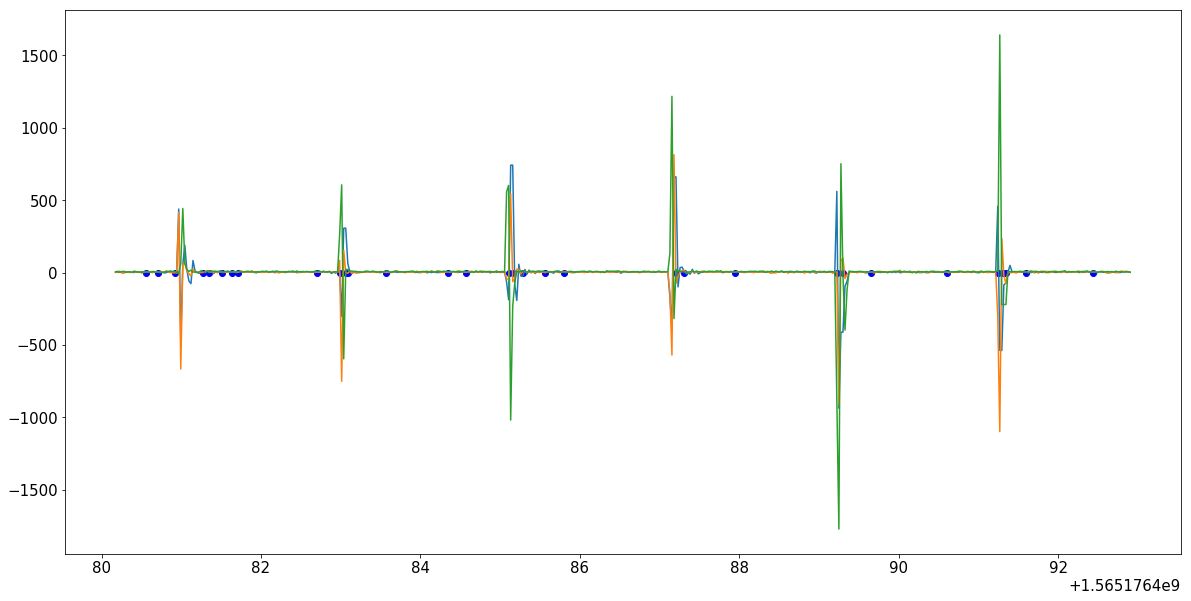

<Figure size 1440x720 with 0 Axes>

In [257]:
import s3fs
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model, model_from_json
import time
import boto3
import os

def upload_to_s3(path):
    s3 = boto3.resource('s3')
    data = open(path, "rb")
    s3.Bucket("-").put_object(Key=path, Body=data, ACL="public-read-write") 
    
def delete_files_s3(x):
    s3 = boto3.resource('s3')
    i=1
    for i in range(0,x):
        path = 'output/' + str(i) + '.json'
        s3.Object('-', path).delete()
        i+=1
    
def json_for_visualisation(anomaly):
    return {"anomaly": anomaly}

def save_json_for_visualisation(j, anomaly):
    file_name = str(j)+(".json")
    with open(str('output/'+file_name), 'w') as f:
        json.dump(json_for_visualisation(anomaly), f, ensure_ascii=False, indent=4)
        
columns = ['measurement', 'timestamp', 'value_x', 'value_y', 'value_z']
df = pd.DataFrame(columns = columns)

plt.rcParams.update({'font.size': 20})

def main(df):
    with open('model_architecture.json', 'r') as f:
        model = model_from_json(f.read())
    model.load_weights('accelerometr_model.h5')
    i=1
    j=1
    fs = s3fs.S3FileSystem()
    s3 = boto3.resource('s3')
#     for i in range(1,500):
    while True:    
        try:
            file = 'localisation' + str(i) + ".json"
            with fs.open(file) as f: 
                data = json.load(f)
                file_name = str(i)
                frame1 = [str(file_name), data["timestamp"], data["value_x"], data["value_y"], data["value_z"] ]   
                frame = pd.DataFrame( [frame1], columns = columns)
                df = df.append(frame, sort=False)
                i+=1  
        except:
            time.sleep(0.05)
            continue
        finally:
            #Delete single peak
            if (200<int(df["value_y"].tail(1))<300 or -300<int(df["value_y"].tail(1))<-200) and \
            (int(df["value_y"].tail(2).head(1))>300 or int(df["value_y"].tail(2).head(1))<200):
                df.iloc[-1:,3] = df.iloc[-2:-1,3]
            elif (200<int(df["value_x"].tail(1))<300 or -300<int(df["value_x"].tail(1))<-200) and \
            (int(df["value_x"].tail(2).head(1))>300 or int(df["value_x"].tail(2).head(1))<200):
                df.iloc[-1:,2] = df.iloc[-2:-1,2]
            elif (200<int(df["value_z"].tail(1))<300 or -300<int(df["value_z"].tail(1))<-200) and \
            (int(df["value_z"].tail(2).head(1))>300 or int(df["value_z"].tail(2).head(1))<200):
                df.iloc[-1:,4] = df.iloc[-2:-1,4]
            
            if len(df) >= 5: 
                x = df.tail(5).iloc[:,2].values
                x = np.append(x, df.tail(5).iloc[:,3].values)
                x = np.append(x, df.tail(5).iloc[:,4].values)
                x = np.array([x])
                pred = model.predict(x) 
                if pred[0][0] <= 0.5 and pred[0][1] >= 0.5:
                    anomaly = False
                    save_json_for_visualisation(j, anomaly)     
                elif pred[0][0] >= 0.5 and pred[0][1] < 0.5:
                    anomaly = True
                    save_json_for_visualisation(j, anomaly)
                else:
                    anomaly = None
                file_output = 'output/' + str(j) + ".json"
                upload_to_s3(file_output) #Zapisywanie plików na S3
                j+=1
            else:
                pass
    return df

df = main(df)
plt.figure(figsize=(20, 10))
plt.plot(df['timestamp'], df['value_y'], df['timestamp'], df['value_x'], df['timestamp'], df['value_z'])
# plt.scatter(s0, s1, color='red')
plt.scatter(t0, t1, color='blue')
plt.figure(figsize=(20, 10))


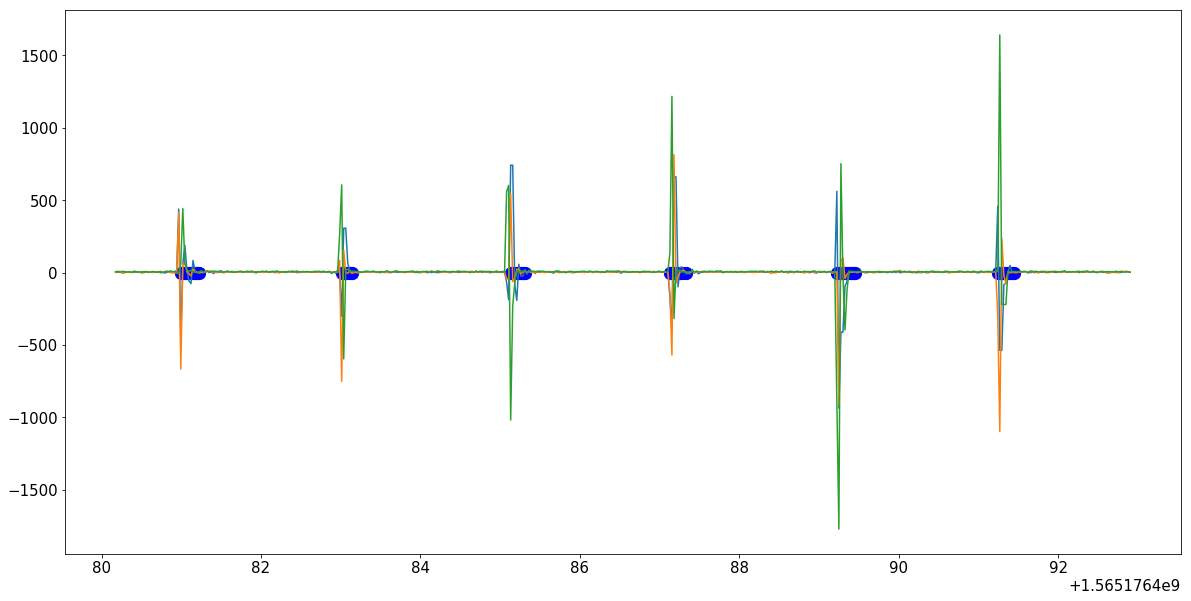

In [259]:
plt.figure(figsize=(20, 10))
plt.plot(df['timestamp'], df['value_y'], df['timestamp'], df['value_x'], df['timestamp'], df['value_z'])
# plt.scatter(s0, s1, color='red')
plt.scatter(s0, s1, color='blue', s=150)

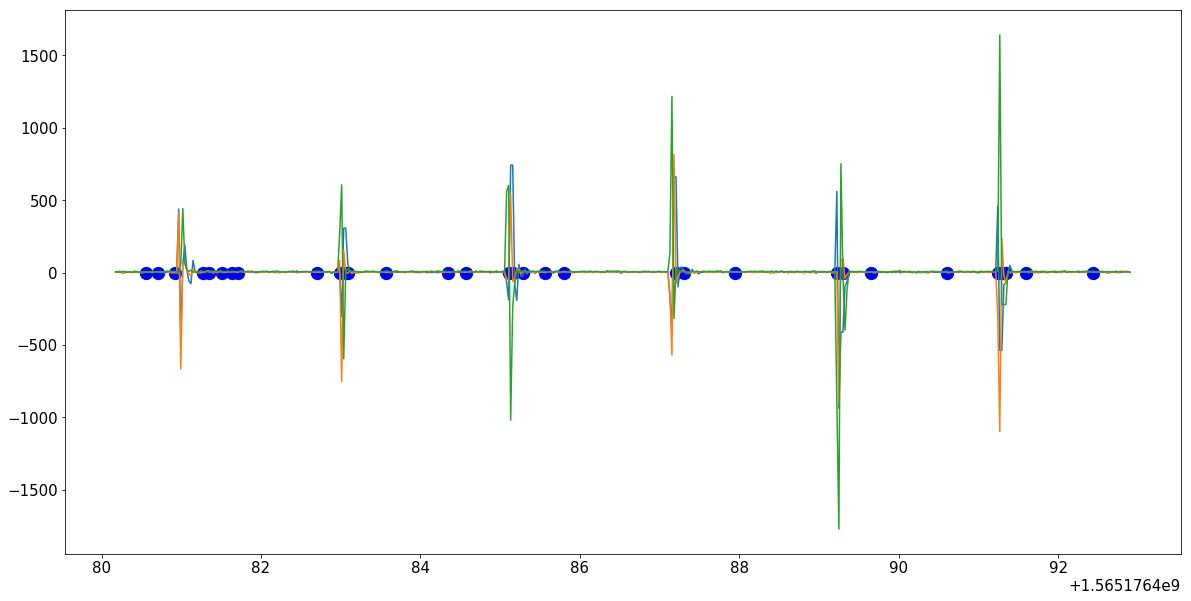

In [258]:
plt.figure(figsize=(20, 10))
plt.plot(df['timestamp'], df['value_y'], df['timestamp'], df['value_x'], df['timestamp'], df['value_z'])
# plt.scatter(s0, s1, color='red')
plt.scatter(t0, t1, color='blue', s=150)

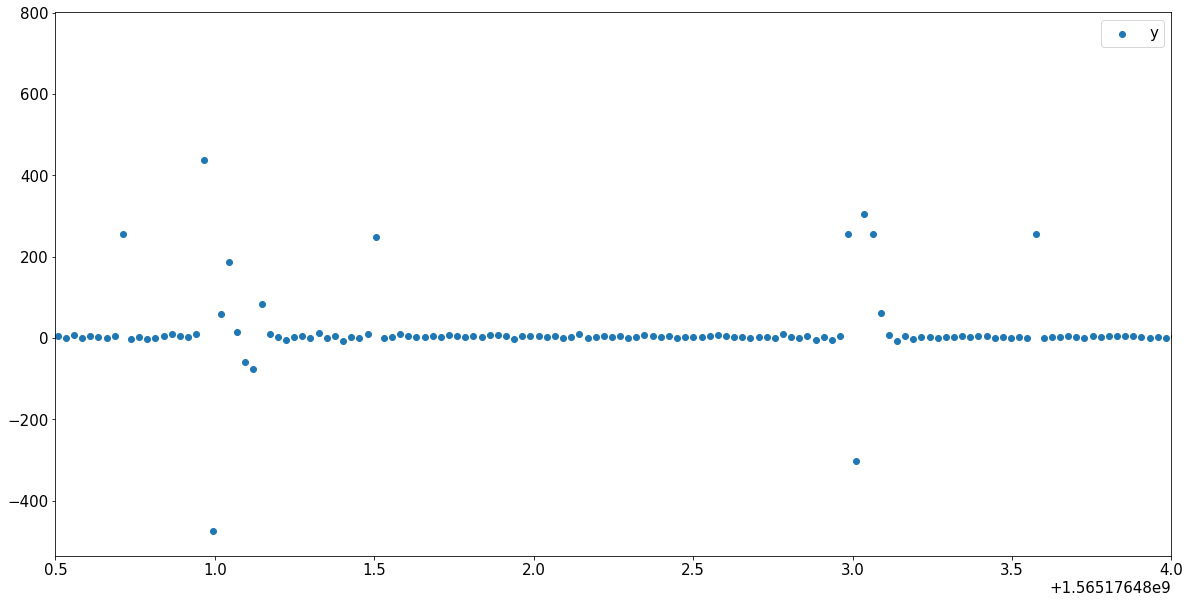

In [117]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20, 10))

plt.scatter(df['timestamp'], df['value_y']) # df['timestamp'], df['value_x'], df['timestamp'], df['value_z'])
plt.xlim(80.5+1.5651764e+09, 84+1.5651764e+09) 
plt.legend(["y", "x", "z"])

plt.show()

In [ ]:
def delete_json_for_visualisation(x):
    for i in range(1,x+1):
        file_name = 'output/' + str(i)+(".json")
        try:
            os.remove(str(file_name))   
        except:
            pass
        
delete_files_s3(310)
delete_json_for_visualisation(300)

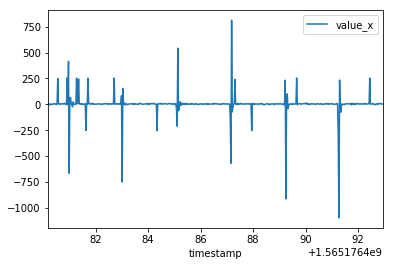

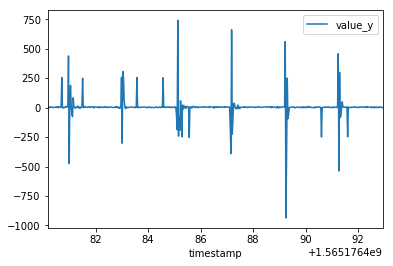

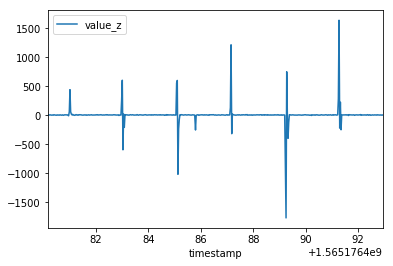

In [25]:
df.plot(x="timestamp", y="value_x")
df.plot(x="timestamp", y="value_y")
df.plot(x="timestamp", y="value_z")

plt.show()